
# Filtering of (mesoscale + tide + noise) time series

The goal is to extract a mesoscale signal and a tidal signal from a noisy observation of their sum.
The method emploies a linear fit on a slow signal (defined by its decorrelation time scale), and tidal harmonics over windows of varying size
and for varying ratios of mesoscale to tidal amplitudes.


---

## Description of synthetic signals

The time series is assumed to be the sum of a mesoscale signal (defined by its spectral shape) and a tidal signal.
The tidal signal may be the sum of two harmonics or have a complex amplitude that is slowly modulated in time.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal

# project figure directory
fpath=%pwd
fpath+='/figs/'

def generate_slow(t=None,T=365.*3,dt=1./24.,Tcut=50,rms=0.2):
    """ generate a sea level corresponding to QG turbulence, i.e.
    a flat spectrum at frequencies lower that Tcut
        
    Parameters
    ----------
        t:
            time line in days
        T:
            time period in days, default corresponds to 3 years
        dt:
            time interval in days, default corresponds to 1h
        Tcut:
            period cutoff for the spectrum in days, default is 50 days
        rms:
            signal rms, default is 0.2
    """
    
    if t is None:
        t=np.arange(0.,T,dt)
    N=t.size
    
    # build frequency line
    omega = 2.*np.pi*np.fft.fftfreq(N,dt)
    omega_cut = 2.*np.pi/Tcut
    
    # create a distribution with right spectral properties
    eta_f = np.exp(1j*np.random.uniform(high=1.,size=N)*2.*np.pi)
    eta_f[np.where(np.abs(omega)>omega_cut)] = eta_f[np.where(np.abs(omega)>omega_cut)] \
                                * omega_cut/omega[np.where(np.abs(omega)>omega_cut)]
    
    # inverse fft
    eta=np.real(np.fft.ifft(eta_f))
    
    # renormalize
    eta = rms * eta / np.std(eta)
    
    return eta, t



def generate_tide(t=None,T=365.*3,dt=1./24.,omega=2.,rms=0.01, omega2=None, Tmod=20., Amod=0.001,plot=False):
    """ generate a tidal (time periodic) signal
    The signal is by default the sum of a stationary signal and a nonstationary signal (time modulated
    noise with cutoff timescale and amplitude prescribed).
    It can also be a fully stationary signal with one or two frequencies
    
    Parameters
    ----------
        t:
            time line in days
        T:
            time period in days, default corresponds to 3 years
        dt:
            time interval in days, default corresponds to 1h
        omega:
            iwave frequency in cycle per days, default is 2 cpd
        rms:
            iwave rms
        omega2:
            second iwave frequency in cycle per days
        Tmod:
            modulation cutoff time scale in days
        Amod:
            modulation amplitude in rms units
        
    """
    
    if t is None:
        t=np.arange(0.,T,dt)
    N=t.size
    dt=t[1]-t[0]
    
    #
    eta = np.cos(2.*np.pi*omega*t)

    # spring neap type modulations
    if omega2 is not None:
        eta += 0.5*np.cos(2.*np.pi*omega2*t)

    # noisy/unstationary modulations
    if Tmod is not None:
        # start from normal random variables
        Ar = np.random.normal(scale=Amod/rms,size=2*t.size)
        Ai = np.random.normal(scale=Amod/rms,size=2*t.size)
        # low pass filter time series
        Ar = low_pass(Ar,t,Tmod,plot=False)[np.int(0.5*t.size):][:t.size]
        Ai = low_pass(Ai,t,Tmod,plot=False)[np.int(0.5*t.size):][:t.size]
        # renormalize rms
        Ar = 1. + Ar/np.std(Ar) * Amod/rms
        Ai = 0. + Ai/np.std(Ai) * Amod/rms
        #
        A = Ar+1j*Ai
        # = 
        #phi0 = np.pi*np.random.uniform(low=-1.,high=1.,size=2*t.size)
        #phi = low_pass(phi0,t,Tmod,plot=False)
        #phi = phi[np.int(0.5*t.size):]; phi = phi[:t.size]
        #phi = np.pi*phi/np.std(phi)
        #
        # A = 1 # could it be random too?
        #
        if plot:
            plt.figure()
            #phi0 = phi0[np.int(0.5*t.size):]; phi0 = phi0[:t.size]
            #plt.plot(t,phi0,'k', label())
            #plt.plot(t,phi,'k')
            plt.plot(t,Ar,'k',label='real(A)')
            plt.plot(t,Ai,'r',label='imag(A)')
            plt.legend(loc=0)
            plt.grid()
            plt.title('Phase of the tidal signal')
            plt.show()
        #eta = np.cos(2.*np.pi*omega*t+phi)
        eta = np.real(A * np.exp(1j*2.*np.pi*omega*t))

    # renormalize
    eta = rms * eta / np.std(eta)
    
    return eta, t

In [3]:
#
# utils functions
#



# Skill

def skill(vtrue,v,t=None, Tedge=None):
    """ compute the skill of a reconstruction (v) of the vtrue signal
    """
    if Tedge is not None:
        if t is not None:
            vtrue = vtrue[np.where( (t>t[0]+Tedge) & (t<t[-1]-Tedge))]
            v = v[np.where( (t>t[0]+Tedge) & (t<t[-1]-Tedge))]
        else:
            print 'skill: You need provide a time line if Tedge is specified'
            print '       proceeds without triming of edges'

    skill = 1. - np.std(vtrue-v)/np.std(vtrue)

    return skill




# filtering functions

def low_pass(v,t,Tcut,plot=False):
    """ Create and apply a low pass filter
    Input parameters:
        a time series v
        a time line t
        a cutoff period
        a flag in order to plot the filter and its properties
    """
    
    dt=t[1]-t[0]
    
    b = signal.firwin(np.int(10*Tcut/dt), 1./Tcut,nyq=1/2./dt)
    
    if plot:
        plt.figure()
        plt.plot(np.arange(0.,b.size)*dt,b)
        plt.xlabel('t [days]')
        plt.figure()
        w, h = signal.freqz(b)
        plt.semilogx(w, np.abs(h))
        plt.show()

    v = np.convolve(v,b,mode='same')

    return v



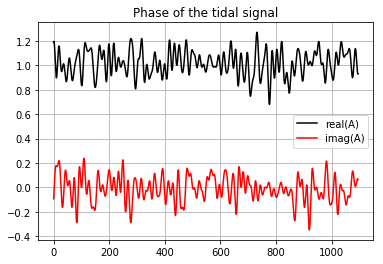

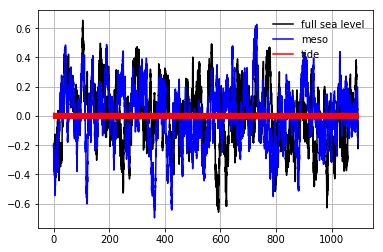

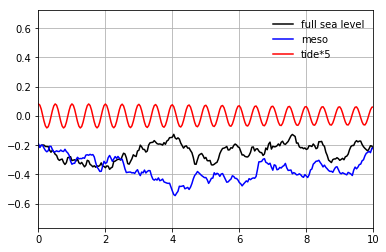

In [15]:

### build time series

# slow signal
eta_meso, t = generate_slow()
# single consistuent, no modulations
#eta_tide, t = generate_tide(t, rms=0.01, omega2=None, Tmod=None)
# single consistuent, with modulations
eta_tide, t = generate_tide(t, rms=0.01, omega2=None, Tmod=15, Amod=0.001, plot=True)
# full signal
eta = eta_meso + eta_tide



# plot time series
plt.figure()
plt.plot(t,eta,'k',label='full sea level')
plt.plot(t,eta_slow,'b',label='meso')
plt.plot(t,eta_tide,'r',label='tide')
plt.grid()
plt.legend(frameon=False)
plt.show()


plt.figure()
plt.plot(t,eta,'k',label='full sea level')
plt.plot(t,eta_slow,'b',label='meso')
plt.plot(t,eta_tide*5.,'r',label='tide*5')
plt.xlim(0,10)
plt.grid()
plt.legend(frameon=False)
plt.show()




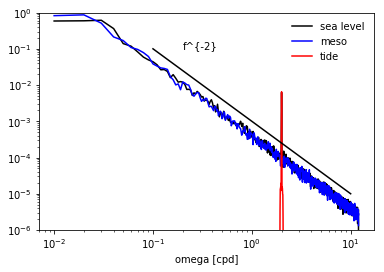

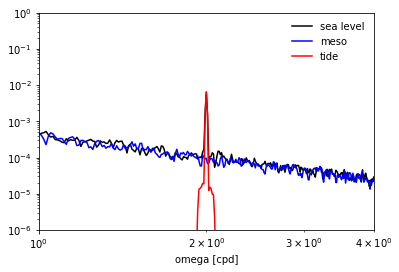

In [16]:
# compute spectrum to check it satisfies the spectrum prescribed
# compare spectra

dt=t[1]-t[0]
Nw=100/dt
f, E = signal.welch(eta, 1/dt, nperseg=Nw)
f, E_slow = signal.welch(eta_slow, 1/dt, nperseg=Nw)
f, E_tide = signal.welch(eta_tide, 1/dt, nperseg=Nw)

# plot spectra
plt.figure()
plt.loglog(f,E,'k',label='sea level')
plt.loglog(f,E_slow,'b',label='meso')
plt.loglog(f,E_tide,'r',label='tide')
fref = np.array([1e-1,1e1])
plt.loglog(fref,1e-3*fref**-2,'k')
plt.text(2*1e-1,1e-1,'f^{-2}')
plt.xlabel('omega [cpd]')
plt.ylim(1e-6,1e0)
plt.legend(frameon=False)
plt.show()



# plot spectra, with a zoom around tidal peaks
plt.figure()
plt.loglog(f,E,'k',label='sea level')
plt.loglog(f,E_slow,'b',label='meso')
plt.loglog(f,E_tide,'r',label='tide')
plt.xlabel('omega [cpd]')
plt.ylim(1e-6,1e0)
plt.xlim(1.,4.)
plt.legend(frameon=False)
plt.show()


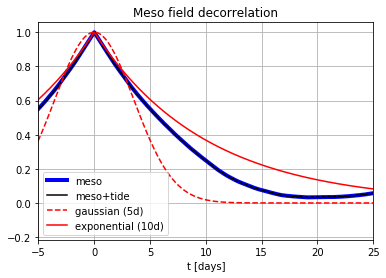

In [17]:
#
#  compute the autocorrelation and plot it

def get_autocor(eta,t):
    C = signal.correlate(eta,eta)
    imax = eta.size-1 # after trial&error
    lags = np.arange(C.size)*(t[1]-t[0])
    lags += -lags[imax]
    C *= 1/C[imax]
    return C, lags

C_meso, lags = get_autocor(eta_meso,t)
C_tide, lags = get_autocor(eta_tide,t)
C_mesotide, lags = get_autocor(eta_meso+eta_tide,t)

fig = plt.figure()
ax=plt.subplot(111)
plt.plot(lags,C_meso,'b',label='meso',lw=4)
plt.plot(lags,C_mesotide,'k',label='meso+tide')
#plt.plot(lags,C_mesotide,'b',label='meso+tide')
plt.plot(lags,np.exp(-(lags/5.)**2),'r--',label='gaussian (5d)')
plt.plot(lags,np.exp(-np.abs(lags/10.)),'r',label='exponential (10d)')
plt.xlim((-5.,25.))
plt.grid()
plt.xlabel('t [days]')
plt.title('Meso field decorrelation')
plt.legend(loc=3)
plt.show()

[  1.00766437e-05   1.01687753e-05]


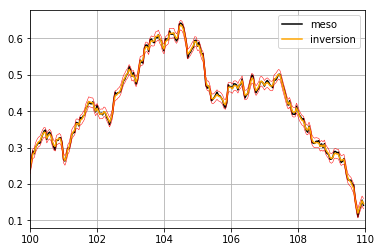

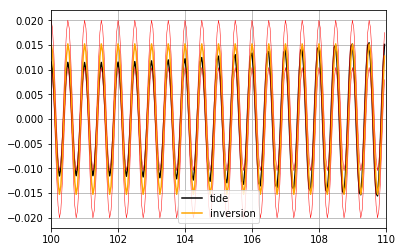

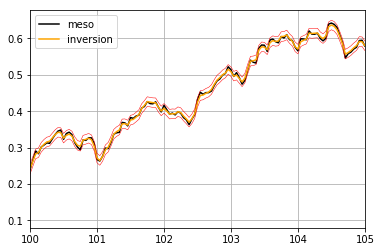

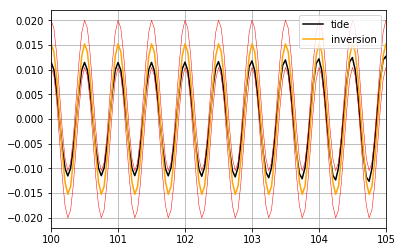

In [40]:
#
# select a smaller time window and filter data
#

# parameters
lomega=2.

leta = (eta_meso+eta_tide)[iwin,None]

#
t0 = 100.
Twin = 10.
iwin = np.where((t>=t0)&(t<t0+Twin))[0]

# generate the sliding window
dt = t[1]-t[0]
twin = np.arange(-Twin*.5,Twin*.5,dt)
T1, T2 = np.meshgrid(twin,twin)

# setup the linear operator
E = np.eye(twin.size)
E = np.hstack((E,np.cos(2.*np.pi*lomega*twin[:,None]),np.sin(2.*np.pi*lomega*twin[:,None])))

# prescribe covariance matrices
#Rxx = np.exp(-((T1-T2)/5.)**2) * eta_meso.std()**2 # gaussian
Rxx = np.exp(-np.abs((T1-T2)/10.)) * eta_meso.std()**2 # exponential
Rxx = np.hstack((Rxx,np.zeros((Rxx.shape[0],2))))
Rxx = np.vstack((Rxx,np.hstack((np.zeros((2,Rxx.shape[0])),np.eye(2)*0.01**2))))
#
#Rnn = np.eye(twin.size) * (noise.std())**2
Rnn = np.eye(twin.size) * .01**2

# perform the smoothing
M = np.dot(E,np.dot(Rxx,E.T)) + Rnn
x_tilde = Rxx.dot(np.dot(E.T,np.linalg.solve(M,leta)))
n_tilde = leta - np.dot(E,x_tilde)
P = np.diag( Rxx - np.dot(Rxx, np.dot(E.T, np.dot( np.linalg.inv(M), np.dot(E,Rxx) ) ) ) )

# decompose in mesoscale and tidal parts
xm_tilde = x_tilde[:-2,0]
Pm = P[:-2]
xt_tilde = np.dot(E[:,-2:],x_tilde[-2:])
Pt = np.max(P[-2:])
print P[-2:]

# plot time series
plt.figure()
#plt.plot(t[iwin],leta,'k',label='meso+tide')
plt.plot(t[iwin],eta_meso[iwin],'k',label='meso')
plt.plot(t[iwin],xm_tilde[:],'orange',label='inversion')
plt.plot(t[iwin],xm_tilde[:] + 1.5*np.sqrt(Pm),'r-',lw=.5)
plt.plot(t[iwin],xm_tilde[:] - 1.5*np.sqrt(Pm),'r-',lw=.5)
plt.grid()
plt.legend()
plt.xlim((t0,t0+Twin))
plt.show()

plt.figure()
plt.plot(t[iwin],eta_tide[iwin],'k',label='tide')
plt.plot(t[iwin],xt_tilde[:],'orange',label='inversion')
plt.plot(t[iwin],xt_tilde[:] + 1.5*np.sqrt(Pt),'r-',lw=.5)
plt.plot(t[iwin],xt_tilde[:] - 1.5*np.sqrt(Pt),'r-',lw=.5)
plt.grid()
plt.legend()
plt.xlim((t0,t0+Twin))
plt.show()

#

plt.figure()
#plt.plot(t[iwin],leta,'k',label='meso+tide')
plt.plot(t[iwin],eta_meso[iwin],'k',label='meso')
plt.plot(t[iwin],xm_tilde[:],'orange',label='inversion')
plt.plot(t[iwin],xm_tilde[:] + 1.5*np.sqrt(Pm),'r-',lw=.5)
plt.plot(t[iwin],xm_tilde[:] - 1.5*np.sqrt(Pm),'r-',lw=.5)
plt.grid()
plt.legend()
plt.xlim((t0,t0+Twin/2.))
plt.show()

plt.figure()
plt.plot(t[iwin],eta_tide[iwin],'k',label='tide')
plt.plot(t[iwin],xt_tilde[:],'orange',label='inversion')
plt.plot(t[iwin],xt_tilde[:] + 1.5*np.sqrt(Pt),'r-',lw=.5)
plt.plot(t[iwin],xt_tilde[:] - 1.5*np.sqrt(Pt),'r-',lw=.5)
plt.grid()
plt.legend()
plt.xlim((t0,t0+Twin/2.))
plt.show()

(240, 242)
(242, 242)


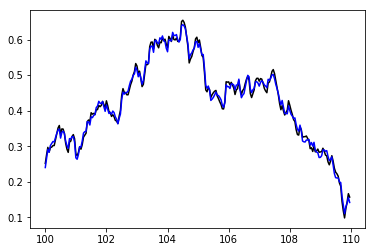

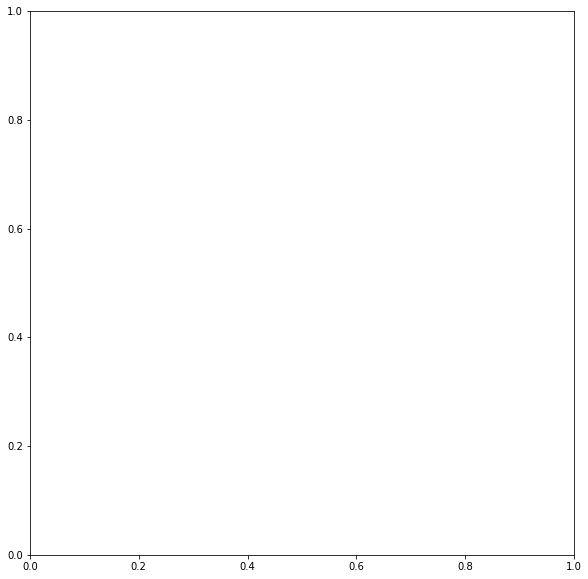

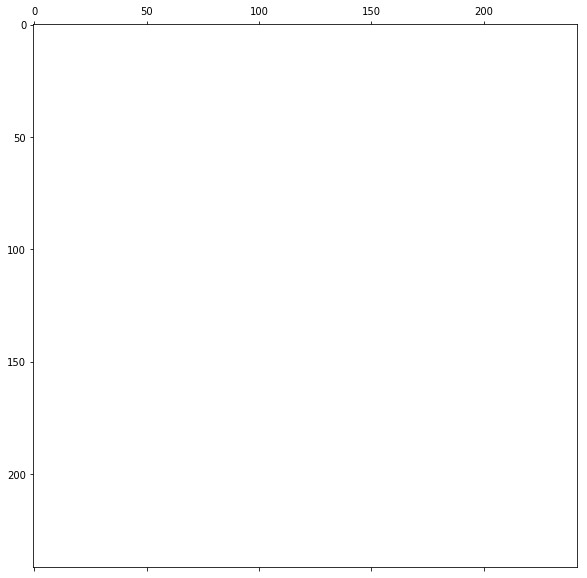

(242, 1)


ValueError: x and y must have same first dimension, but have shapes (240,) and (242, 1)

In [23]:
# recompute covariances
lRxx_true, llags = get_autocor(eta_meso[iwin,None],t[iwin,None])
lRxx, llags = get_autocor(x_tilde,t[iwin,None])
lRnn, llags = get_autocor(n_tilde,t[iwin,None])

fig = plt.figure()
ax=plt.subplot(111)
plt.plot(lags,C_meso,'b',label='meso')
plt.plot(llags,lRxx_true,'orange',label='meso sample')
plt.plot(lags,np.exp(-np.abs(lags/10.)),'r',label='exponential (10d)')
plt.plot(llags,lRxx,'b--',label='meso estimated')
plt.plot(llags,lRnn,'g--',label='noise estimated')
plt.xlim((-5.,25.))
plt.grid()
plt.xlabel('t [days]')
plt.title('Meso field decorrelation')
plt.legend(loc=1)
plt.show()

# check variance about truth
P_true = np.std( x_tilde[:,0]-eta_meso[iwin] )**2

fig = plt.figure()
ax=plt.subplot(111)
#plt.plot(t[iwin],x_tilde[:,0]-eta_meso[iwin])
plt.plot(t[iwin],P,'k',label='diag(P)')
plt.axhline(y=P_true,color='b',label='diag(P) estimated')
plt.grid()
plt.legend()
plt.xlim((t0,t0+Twin))
plt.show()


---

---

---

---


In [5]:
#
# now test extraction of the tidal signal: well sampled case
#


###########################################################################
# harmonic analysis


def get_tide_ha(v, t, omega=[2.], Twin=5):
    """ Extract the tidal signal with a harmonic analysis on a sliding window
    The fit looks like: v = v0 + v1 x t + sum( vi_c cos(omega x t) + vi_s sin(omega x t))
    """
    
    # generate the sliding window
    dt = t[1]-t[0]
    twin = np.arange(-Twin*.5,Twin*.5+dt,dt)
    T1, T2 = np.meshgrid(twin,twin)
    # find the central point of the window
    i0 = np.where(np.abs(twin)<=1e-10)[0][0]
    X = np.hstack((np.ones_like(twin)[:,None],twin[:,None]*2./Twin))
    #X = np.hstack((np.ones_like(twin)[:,None],np.random.randn(twin.size)[:,None]))
    for lomega in omega:
        X = np.hstack((X,np.cos(2.*np.pi*lomega*twin[:,None]),np.sin(2.*np.pi*lomega*twin[:,None])))
    
    if False:
        plt.figure()
        plt.plot(twin, X)
        plt.ylim(-1.1,1.1)
        plt.xlabel('time [days]')
        plt.title('window fit functions')
        plt.grid()
        plt.show()
    
    # convolve the original time series with fit functions
    Xc =[]
    for i in xrange(X.shape[1]):
        Xc.append(np.convolve( v, X[:,i], mode='same'))
    # normalize and correct for cross-correlations
    M = np.linalg.inv(X.transpose().dot(X))
    m = M.dot(np.array(Xc))
    
    #print m.shape, X.shape, M.shape
    #V = m.transpose() * X[i0,:].transpose()
    V = X[i0,:]*m.transpose() # watch out for the broadcast

    # separates low and tidal parts
    v_tide = np.sum(V[:,2:], axis=1)
    v_slow = V[:,0]+V[:,1]
    
    return V, v_tide, v_slow

### Note on the use of the convolve function

We want to compute for each $n$ (time index):

$\sum_k v(n+k) X(k,:) = \sum_m v(m) X(m-n,:)$

which is the convolution exactly:

https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

In [6]:
### perform the harmonic analysis and compute skills

# full signal
V, eta_ha_tide, eta_ha_slow = get_tide_ha(eta, t)
skill_eta_tide = skill(eta_tide, eta_ha_tide, t=t, Tedge=5)

# true tidal signal: check
Vt, etat_ha_tide, etat_ha_slow = get_tide_ha(eta_tide, t)
skill_etat_tide = skill(eta_tide, etat_ha_tide, t=t, Tedge=5)


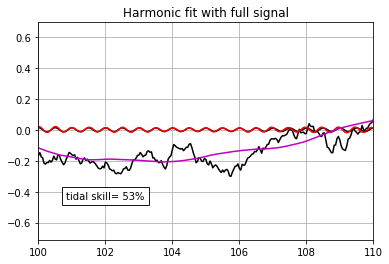

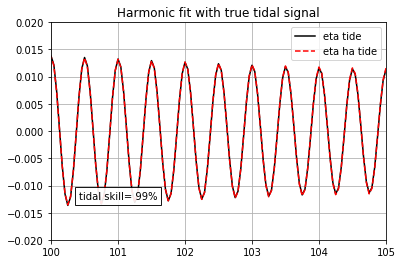

In [7]:
### plot the result of the fit: overview
off=0.1
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(t,eta,'k')
plt.plot(t,eta_tide,'k',label='eta tide')
#plt.plot(t,eta_tide_bpfilt,'g', label='eta tide bdpass')
plt.plot(t,eta_ha_tide,'r',label='eta ha tide')
plt.plot(t,eta_ha_slow,'m',label='eta ha slow')
plt.xlim(100,110)
#plt.ylim(-.3,.3)
ax.text(0.2, 0.2,'tidal skill= %.0f' %(skill_eta_tide*1e2) +'%', bbox=dict(facecolor='w', alpha=0.9),
        horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)
plt.grid()
plt.title('Harmonic fit with full signal')
plt.show()



### plot the result of the fit: tidal part
fig=plt.figure()
ax = fig.add_subplot(111)
plt.plot(t,eta_tide,'k',label='eta tide')
#plt.plot(t,eta_tide_bpfilt,'g', label='eta tide bdpass')
plt.plot(t,etat_ha_tide,'r--',label='eta ha tide')
#plt.plot(t,etat_ha_slow,'m',label='eta ha slow')
plt.xlim(100,105)
#plt.ylim(-.3,.3)
ax.text(0.2, 0.2,'tidal skill= %.0f' %(skill_etat_tide*1e2) +'%', bbox=dict(facecolor='w', alpha=0.9),
        horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)
plt.grid()
plt.title('Harmonic fit with true tidal signal')
plt.legend()
plt.show()


---

## One stationary constituent


In [8]:
# 1 constituent: build map of skill as a function of SNR and window length
# (still well-sampled case)

# regenerate tidal signal (safer)
eta_tide, t = generate_tide(t, rms=0.01, omega2=None, Tmod=None)

# build rms slow - Twin grid
rms_slow = 10.**np.arange(-3.,0.1,.1)
Twin = np.arange(1,100,2)

# main loop
skill_map = np.zeros((rms_slow.size,Twin.size))
for i, lrms_slow in enumerate(rms_slow):
    eta_slow, t = generate_slow(rms=lrms_slow)
    leta = eta_slow+eta_tide
    for j, lTwin in enumerate(Twin):
        V, leta_ha_tide, leta_ha_slow = get_tide_ha(leta, t, Twin=lTwin)
        skill_map[i,j]= skill(eta_tide, leta_ha_tide, t=t, Tedge=lTwin)
        #print i,j

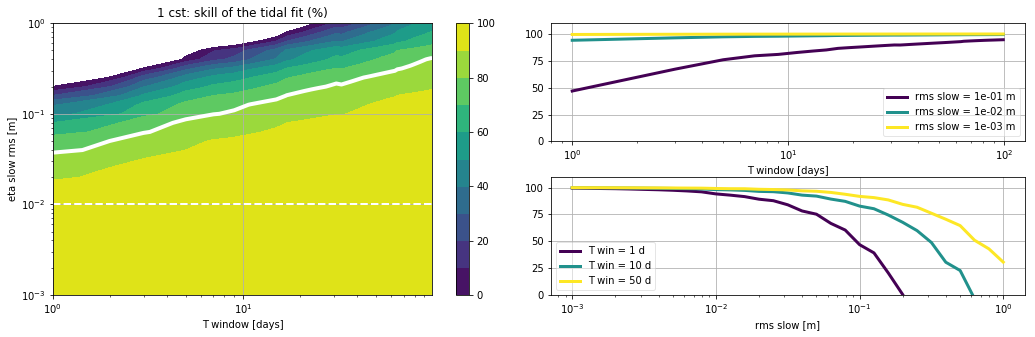

In [9]:
### create a default function in order to plot skill map

def plot_skill(Twin,rms_slow,skill_map,title='', fname=None):
    
    fig=plt.figure(figsize=(15,5))
    axes=[]
    gs = gridspec.GridSpec(2, 2)
    gs.update(left=0.05, right=0.95, wspace=0.05,hspace=.3)

    #
    ax = plt.subplot(gs[:, :-1])
    lvls=np.arange(0.,1.05,.1)*1e2
    im=ax.contourf(Twin,rms_slow,skill_map*1e2,lvls,cmap=plt.cm.viridis)
    imc=ax.contour(Twin,rms_slow,skill_map,levels=[0.8],colors='w',lw=3,linewidths=4)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('T window [days]')
    ax.set_ylabel('eta slow rms [m]')
    ax.axhline(np.std(eta_tide),color='w',ls='--',lw=2)
    ax.grid(which='major')
    ax.set_title(title+': skill of the tidal fit (%)')
    plt.colorbar(im)
    axes.append(ax)

    #
    ax = plt.subplot(gs[0, -1])
    rms_slow_lvls=[1e-1,1e-2,1e-3]
    line_colors = plt.cm.viridis(np.linspace(0,1,len(rms_slow_lvls)))
    for i, rms in enumerate(rms_slow_lvls):
        ii=np.where(rms_slow>=rms)[0][0]
        plt.plot(Twin,skill_map[ii,:]*1e2,color=line_colors[i],lw=3,label='rms slow = %.0e m'%rms )
        leg = plt.legend(loc=0)
        leg.get_frame().set_alpha(0.5)
        ax.set_xlabel('T window [days]')
        ax.set_xscale('log')
        ax.set_ylim(0,110.)
        plt.grid()
    axes.append(ax)

    #
    Twin_lvls=[1,10,50]
    ax = plt.subplot(gs[-1, -1])
    line_colors = plt.cm.viridis(np.linspace(0,1,len(Twin_lvls)))
    for i, twin in enumerate(Twin_lvls):
        ii=np.where(Twin>=twin)[0][0]
        plt.plot(rms_slow,skill_map[:,ii]*1e2,color=line_colors[i],lw=3,label='T win = %.0f d'%twin )
        leg = plt.legend(loc=0)
        leg.get_frame().set_alpha(0.5)
        ax.set_xlabel('rms slow [m]')
        ax.set_xscale('log')    
        ax.set_ylim(0,110.)
        plt.grid()
    axes.append(ax)

    plt.show()
    if fname is not None:
        fig.savefig(fpath+fname,dpi=300)
    
    return fig, axes, 


# apply the function to the base case
fix, axes = plot_skill(Twin,rms_slow,skill_map,title='1 cst', fname='1cst_skill_map.pdf')

---

## Two stationary constituents

This simulates a spring-neap cycle

In [10]:
# 2 constituents: build map of skill as a function of SNR and window length
# (still well-sampled case)

# the result is very similar

# regenerate tidal signal (safer)
eta_tide, t = generate_tide(t, rms=0.01, omega2=2.+1./14., Tmod=None)

# slow signal
skill_map = np.zeros((rms_slow.size,Twin.size))
for i, lrms_slow in enumerate(rms_slow):
    eta_slow, t = generate_slow(rms=lrms_slow)
    leta = eta_slow+eta_tide
    for j, lTwin in enumerate(Twin):
        V, leta_ha_tide, leta_ha_slow = get_tide_ha(leta, t, Twin=lTwin, omega=[2.,2.+1./14.])
        skill_map[i,j]= skill(eta_tide, leta_ha_tide, t=t,Tedge=lTwin)
        #print i,j

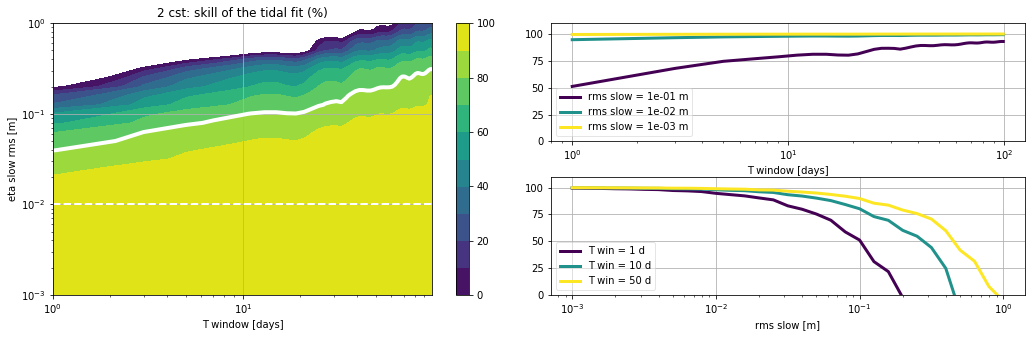

In [ ]:

# plot skill map
fix, axes = plot_skill(Twin,rms_slow,skill_map,title='2 cst', fname='2cst_skill_map.pdf')


In [ ]:
# same but assuming we know only one frequency
skill_map = np.zeros((rms_slow.size,Twin.size))
for i, lrms_slow in enumerate(rms_slow):
    eta_slow, t = generate_slow(rms=lrms_slow)
    leta = eta_slow+eta_tide
    for j, lTwin in enumerate(Twin):
        V, leta_ha_tide, leta_ha_slow = get_tide_ha(leta, t, Twin=lTwin, omega=[2.])
        skill_map[i,j]= skill(eta_tide, leta_ha_tide, t=t,Tedge=lTwin)
        #print i,j
        

In [ ]:

# plot skill map
fix, axes = plot_skill(Twin,rms_slow,skill_map,title='2 cst', fname='2cst_know1_skill_map.pdf')


---

## One non-stationary constituent

In [ ]:
# Incoherent tide: build map of skill as a function of SNR and window length
# (still well-sampled case)

# regenerate tidal signal (safer)
Tmod=15.
#eta_tide, t = generate_tide(t, rms=0.01, omega2=None, Tmod=Tmod, Amod=0.001)
eta_tide, t = generate_tide(t, rms=0.01, omega2=None, Tmod=Tmod, Amod=0.005)
#eta_tide, t = generate_tide(t, rms=0.01, omega2=None, Tmod=Tmod, Amod=0.01)

# slow signal
skill_map = np.zeros((rms_slow.size,Twin.size))
for i, lrms_slow in enumerate(rms_slow):
    eta_slow, t = generate_slow(rms=lrms_slow)
    leta = eta_slow+eta_tide
    for j, lTwin in enumerate(Twin):
        V, leta_ha_tide, leta_ha_slow = get_tide_ha(leta, t, Twin=lTwin, omega=[2.])
        skill_map[i,j]= skill(eta_tide, leta_ha_tide, t=t,Tedge=lTwin)
        #print i,j


In [ ]:

# plot skill map
fig, axes = plot_skill(Twin,rms_slow,skill_map,title='1 incoherent cst', fname=None)
axes[0].axvline(Tmod,color='w',ls='--',lw=2)
fig.savefig(fpath+'1cst_incoh_skill_map.pdf',dpi=300)


In [ ]:
###########################################################################
# Incoherent tide: build map of skill as a function of SNR and window length
# (still well-sampled case)

# regenerate tidal signal (safer)
Tmod=15.

eta_tideA1, t = generate_tide(t, rms=0.01, omega2=None, Tmod=Tmod, Amod=0.001)
eta_tideA2, t = generate_tide(t, rms=0.01, omega2=None, Tmod=Tmod, Amod=0.005) # base case
eta_tideA3, t = generate_tide(t, rms=0.01, omega2=None, Tmod=Tmod, Amod=0.02)

Tmods=[50.,5.]
eta_tideT1, t = generate_tide(t, rms=0.01, omega2=None, Tmod=Tmods[0], Amod=0.005)
#eta_tideT2, t = generate_tide(t, rms=0.01, omega2=None, Tmod=15., Amod=0.005)
eta_tideT3, t = generate_tide(t, rms=0.01, omega2=None, Tmod=Tmods[1], Amod=0.005)


In [ ]:
# compute and shown spectra
dt=t[1]-t[0]
Nw=100/dt
#f, E = signal.welch(eta, 1/dt, nperseg=Nw)
f, E_tideA1 = signal.welch(eta_tideA1, 1/dt, nperseg=Nw)
f, E_tideA2 = signal.welch(eta_tideA2, 1/dt, nperseg=Nw)
f, E_tideA3 = signal.welch(eta_tideA3, 1/dt, nperseg=Nw)
f, E_tideT1 = signal.welch(eta_tideT1, 1/dt, nperseg=Nw)
f, E_tideT3 = signal.welch(eta_tideT3, 1/dt, nperseg=Nw)


# plot spectra
plt.figure()
plt.loglog(f,E,'k')
plt.loglog(f,E_tideA1,'b')
plt.loglog(f,E_tideA2,'b')
plt.loglog(f,E_tideA3,'b')
plt.loglog(f,E_tideT1,'r')
plt.loglog(f,E_tideT3,'r')

fref = np.array([1e-1,1e1])
plt.loglog(fref,1e-3*fref**-2,'k')
plt.text(2*1e-1,1e-1,'f^{-2}')
plt.xlabel('omega [cpd]')
plt.ylim(1e-6,1e0)
plt.show()



# plot spectra, with a zoom around tidal peaks
fig = plt.figure()
ax=plt.subplot(111)
plt.plot(f,E,'k')
plt.plot(f,E_tideA1,'b')
plt.plot(f,E_tideA2,'b')
plt.plot(f,E_tideA3,'b')
plt.plot(f,E_tideT1,'r')
plt.plot(f,E_tideT3,'r')
ax.set_yscale('log')
plt.xlabel('omega [cpd]')
plt.ylim(1e-6,1e-1)
plt.xlim(1.6,2.4)
plt.show()

In [ ]:

# compute skill maps for all 6 cases
skill_maps=[]
for leta_tide in [eta_tideA1, eta_tideA3, eta_tideT1, eta_tideT3]:
    skill_map = np.zeros((rms_slow.size,Twin.size))
    for i, lrms_slow in enumerate(rms_slow):
        eta_slow, t = generate_slow(rms=lrms_slow)
        leta = eta_slow+leta_tide
        for j, lTwin in enumerate(Twin):
            V, leta_ha_tide, leta_ha_slow = get_tide_ha(leta, t, Twin=lTwin, omega=[2.])
            skill_map[i,j]= skill(leta_tide, leta_ha_tide, t=t,Tedge=lTwin)
            #print i,j
    skill_maps.append(skill_map)
    

In [ ]:

# plot all 6 cases

labels=['A1','A3','T1','T3']

for i,skill_map in enumerate(skill_maps):
    
    fname='1cst_incoh_'+labels[i]+'_skill_map.pdf'
    fig, axes = plot_skill(Twin,rms_slow,skill_map,title='1 incoherent cst '+labels[i], fname=fname)
    if i>=2:
        axes[0].axvline(Tmods[i-2],color='w',ls='--',lw=2)
        plt.show()
        fig.savefig(fpath+fname,dpi=300)



In [ ]:
#
# Consider one time and attempt to fit modes, cf discussion with Clement
#




In [ ]:
#
# now test extraction of the tidal signal: poorely sampled case
#


# wavelet approach

# harmonic analysis